Success! Figure saved to assets/barplot_mimic_performance.png


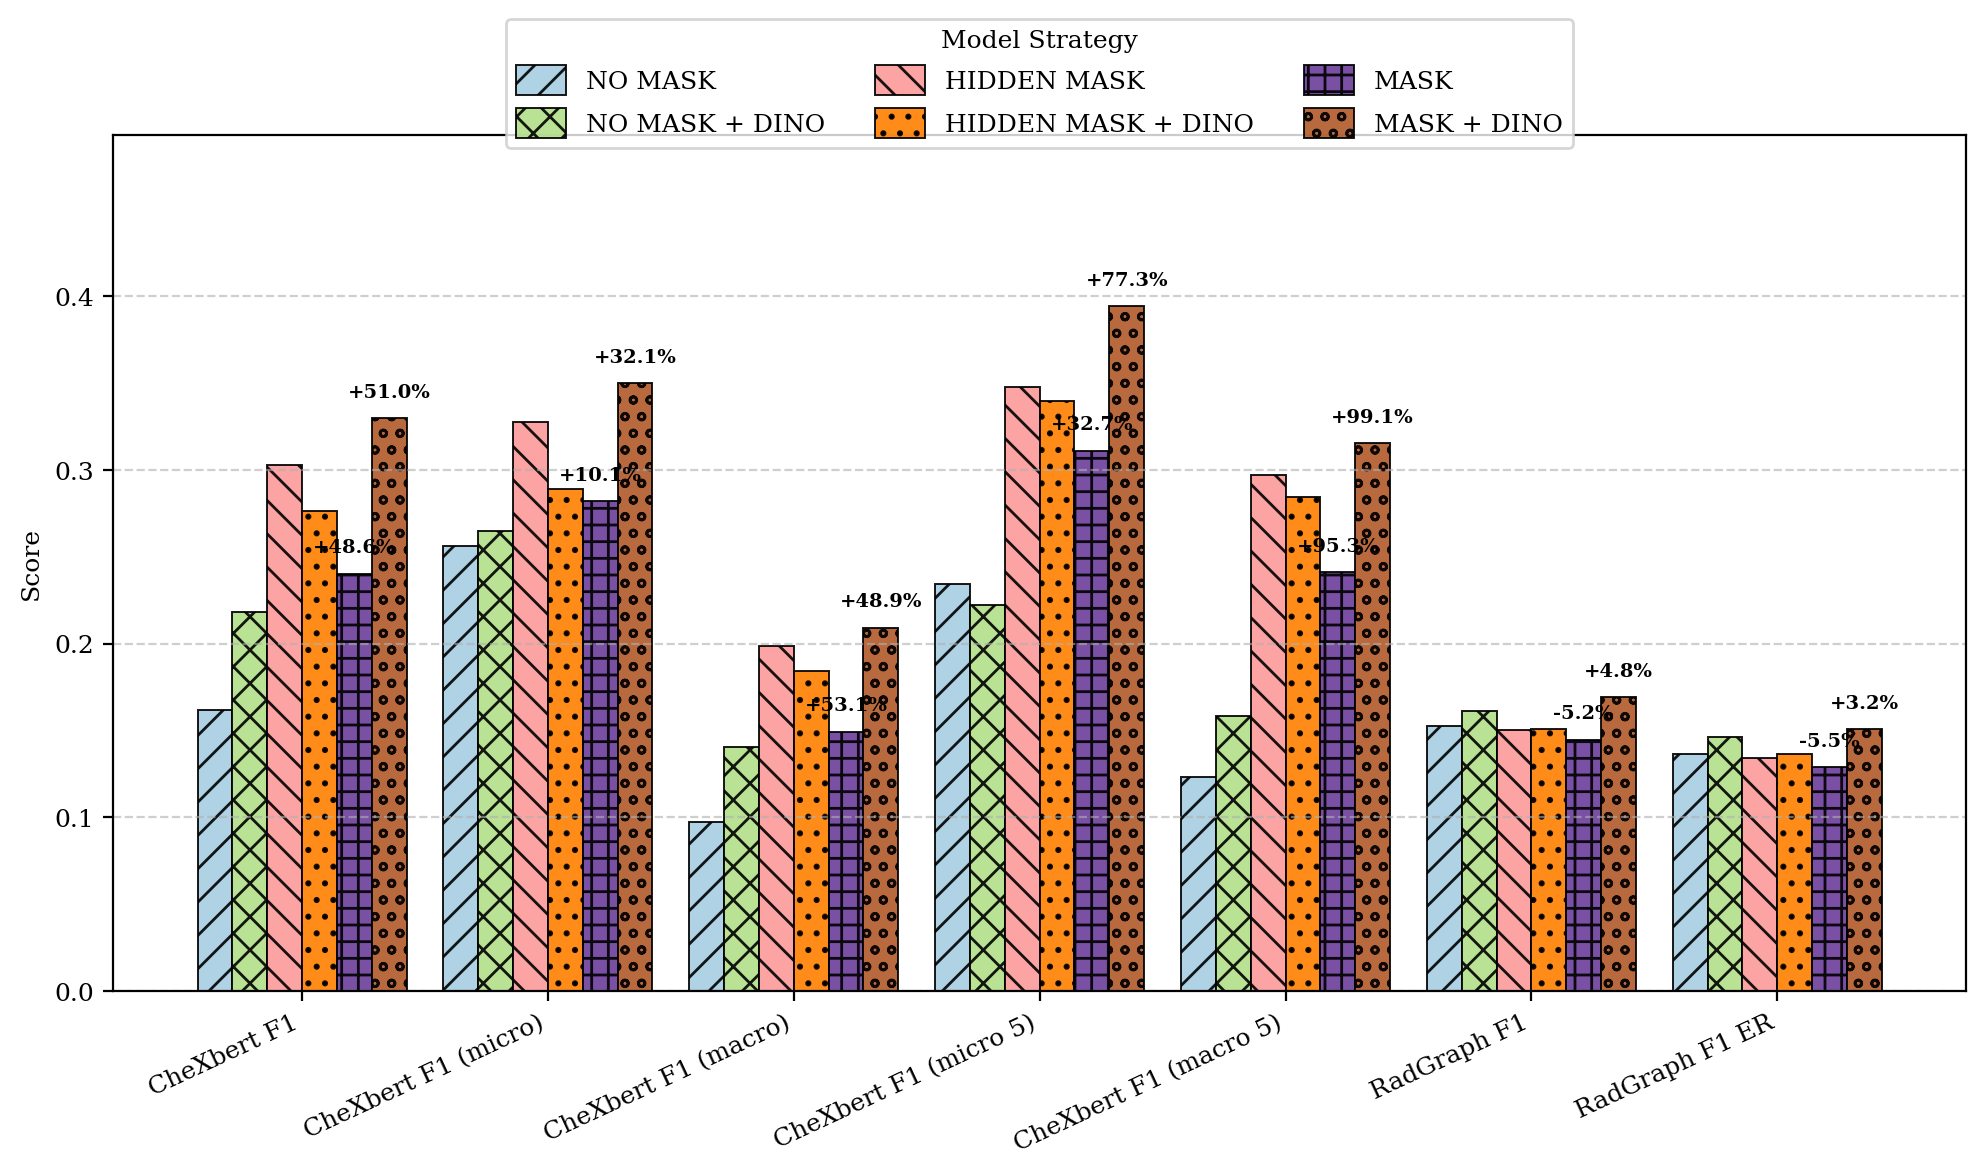

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# ============================================================
# 1. DATA PREPARATION
# ============================================================

def prepare_for_bar_plot(df_original):
    """Selects and renames the metrics for plotting."""
    metric_map = {
        "chexbert_f1_weighted": "CheXbert F1",
        "chexbert_f1_micro":    "CheXbert F1 (micro)",
        "chexbert_f1_macro":    "CheXbert F1 (macro)",
        "chexbert_f1_micro_5":  "CheXbert F1 (micro 5)",
        "chexbert_f1_macro_5":  "CheXbert F1 (macro 5)",
        "radgraph_f1_RG_E":     "RadGraph F1",
        "radgraph_f1_RG_ER":    "RadGraph F1 ER",
    }

    # Filter only metrics that exist in the dataframe index
    metrics_to_plot = [k for k in metric_map.keys() if k in df_original.index]
    
    if not metrics_to_plot:
        return pd.DataFrame()

    df_plot = df_original.loc[metrics_to_plot]
    df_plot = df_plot.rename(index=metric_map)
    return df_plot

# ============================================================
# 2. PLOTTING FUNCTION
# ============================================================

def plot_model_metrics(data_dict, dataset_name):
    if not data_dict:
        print(f"No data found for {dataset_name}.")
        return

    # Global style settings
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 9,
        "figure.dpi": 200,
    })

    df_original = pd.DataFrame(data_dict)
    df_for_plot = prepare_for_bar_plot(df_original.copy())

    if df_for_plot.empty:
        print("No metrics found to plot.")
        return

    # --- Setup Model Order & Renaming ---
    # Ensure these keys match EXACTLY what is in values_selected_mimic
    model_rename_map = {
        'SAMEModGPT2NOMASK': 'NO MASK',
        'SAMEModGPT2NOMASKDINO': 'NO MASK + DINO',
        'SAMEModGPT2HIDDEN': 'HIDDEN MASK',
        'SAMEModGPT2HIDDENDINO': 'HIDDEN MASK + DINO',
        'SAMEModGPT2':       'MASK',
        'SAMEModGPT2DINO': 'MASK + DINO',
    }
    
    model_order = [m for m in model_rename_map.keys() if m in df_for_plot.columns]
    df_plot_filtered = df_for_plot[model_order].rename(columns=model_rename_map)

    metrics = df_plot_filtered.index.tolist()
    model_labels = df_plot_filtered.columns.tolist()
    n_metrics = len(metrics)
    n_models = len(model_labels)

    x = np.arange(n_metrics)
    total_width = 0.85
    bar_width = total_width / n_models

    fig, ax = plt.subplots(figsize=(10, 6))

    # Extended color and hatch palettes
    colors = plt.cm.Paired(np.linspace(0, 1, n_models))
    hatches = ['//', 'xx', '\\\\', '..', '++', 'oo']

    for i, model in enumerate(model_labels):
        offset = (i - (n_models - 1) / 2) * bar_width
        values = df_plot_filtered[model].values

        bars = ax.bar(
            x + offset, values,
            width=bar_width,
            label=model,
            edgecolor='black',
            linewidth=0.7,
            color=colors[i],
            hatch=hatches[i % len(hatches)],
            alpha=0.9
        )

        # Percentage Annotations: Compare 'HIDDEN MASK' vs 'NO MASK'
        if model == 'MASK + DINO' and 'NO MASK + DINO' in df_plot_filtered.columns:
            nomask_values = df_plot_filtered['NO MASK + DINO'].values
            for bar, val_mask, val_nomask in zip(bars, values, nomask_values):
                if val_nomask > 0:
                    pct_diff = ((val_mask - val_nomask) / val_nomask) * 100
                    ax.text(
                        bar.get_x() + bar.get_width() / 2, 
                        bar.get_height() + 0.01, 
                        f"{pct_diff:+.1f}%", 
                        ha='center', va='bottom', fontsize=7, fontweight='bold'
                    )
        # Percentage Annotations: Compare 'HIDDEN MASK' vs 'NO MASK'
        if model == 'MASK' and 'NO MASK' in df_plot_filtered.columns:
            nomask_values = df_plot_filtered['NO MASK'].values
            for bar, val_mask, val_nomask in zip(bars, values, nomask_values):
                if val_nomask > 0:
                    pct_diff = ((val_mask - val_nomask) / val_nomask) * 100
                    ax.text(
                        bar.get_x() + bar.get_width() / 2, 
                        bar.get_height() + 0.01, 
                        f"{pct_diff:+.1f}%", 
                        ha='center', va='bottom', fontsize=7, fontweight='bold'
                    )

    # --- Formatting ---
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=25, ha='right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    
    # Expand Y-axis for annotations and legend
    ax.set_ylim(0, df_plot_filtered.max().max() * 1.25)

    ax.legend(
        title='Model Strategy',
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        ncol=3, 
        frameon=True,
        handlelength=2,
        handleheight=1.5
    )

    plt.tight_layout()
    
    os.makedirs("assets", exist_ok=True)
    save_path = f"assets/barplot_{dataset_name.lower()}.png"
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Success! Figure saved to {save_path}")
    plt.show()

# ============================================================
# 3. EXECUTION
# ============================================================

json_paths_folder = "lstm-vs-gpt/results_complete"

if not os.path.exists(json_paths_folder):
    print(f"Error: Folder {json_paths_folder} not found.")
else:
    json_files = [f for f in os.listdir(json_paths_folder) if f.endswith('.json') and 'MIMIC' in f]
    values_selected_mimic = {}

    for f in json_files:
        # Crucial Fix: Ensure the key matches the "SAMEModGPT2..." format
        # Adjust the split logic if your filenames differ (e.g., 'SAMEModGPT2_results.json')
        model_key = f.split('_')[0] 
        
        file_path = os.path.join(json_paths_folder, f)
        try:
            with open(file_path, 'r') as jfile:
                values_selected_mimic[model_key] = json.load(jfile)
        except Exception as e:
            print(f"Error loading {f}: {e}")

    plot_model_metrics(values_selected_mimic, "MIMIC_Performance")


FULL TABLE: All Models for MIMIC_Complete_Analysis
                         ModGPT2  ModGPT2NOMASK  ModGPT2HIDDEN  ModGPT2DINO  ModGPT2NOMASKDINO  ModGPT2HIDDENDINO
chexbert_f1_micro         0.3159         0.1696         0.2773       0.3328             0.2489             0.3530
chexbert_f1_macro         0.1697         0.0715         0.1341       0.1718             0.1270             0.1522
chexbert_f1_micro_5       0.3370         0.1368         0.2394       0.3710             0.3364             0.3930
chexbert_f1_macro_5       0.2383         0.0832         0.1811       0.2692             0.2505             0.2363
radgraph_f1_RG_E          0.1609         0.1466         0.1578       0.1717             0.1888             0.1722
radgraph_f1_RG_ER         0.1509         0.1314         0.1431       0.1568             0.1686             0.1549
training_time_seconds  1227.2791      1153.5771      1302.5353    1353.4990          1406.4754          1960.5417



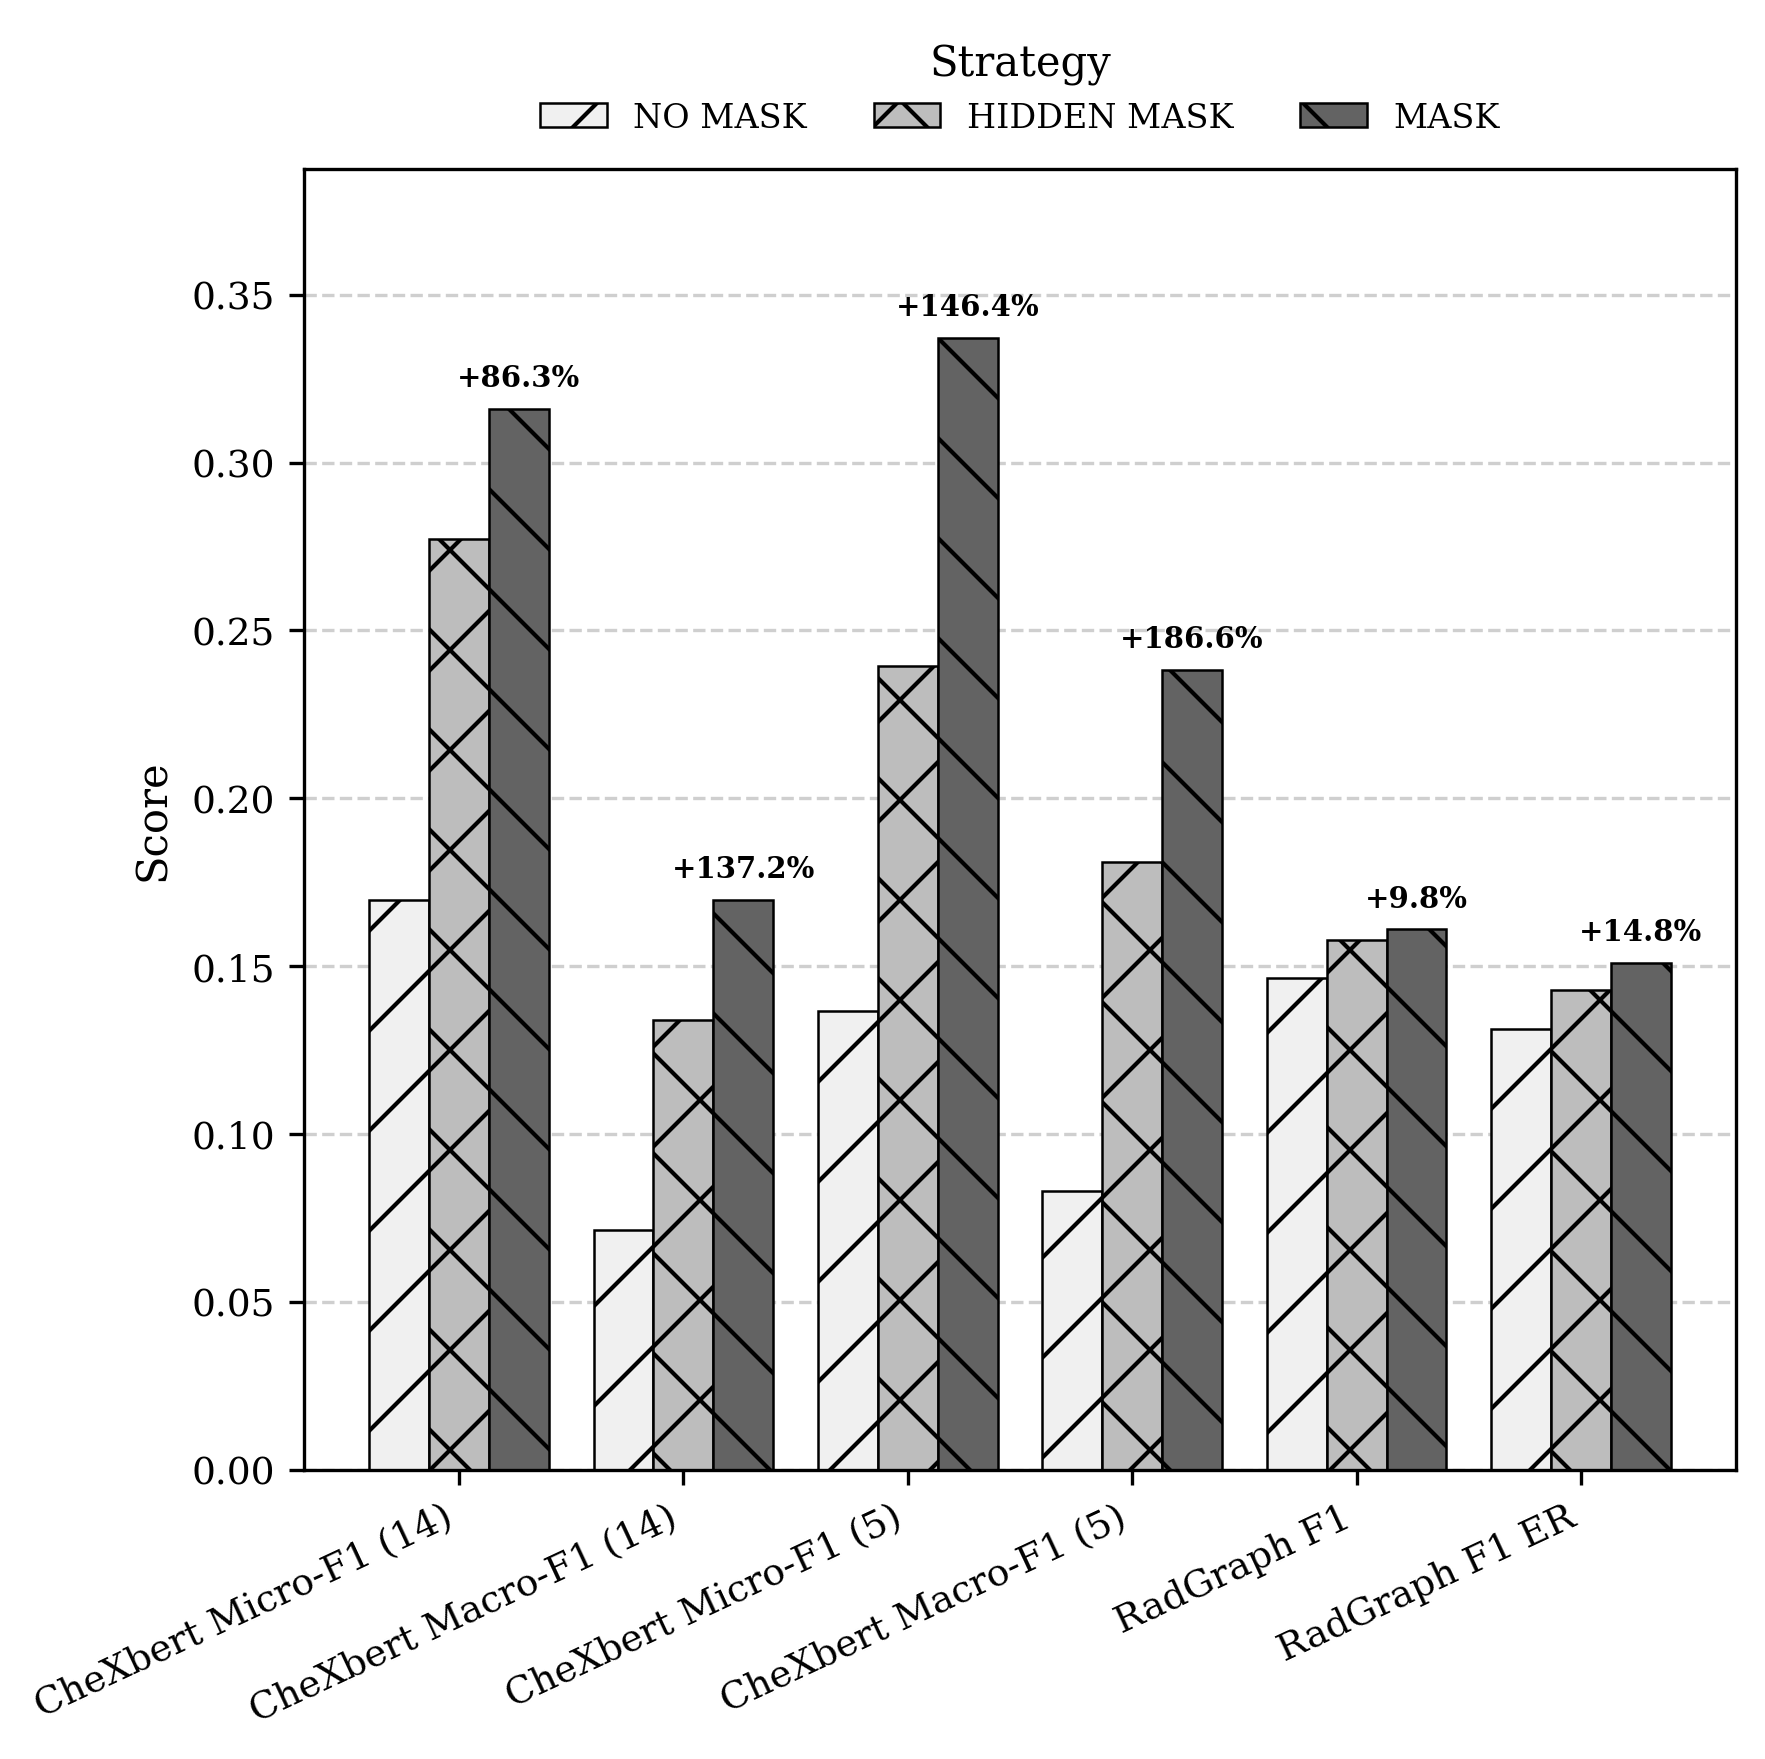

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # Suppress unnecessary warnings for cleaner output


# ============================================================
# 1. DATA PREPARATION
# ============================================================

def prepare_for_bar_plot(df_original):
    """
    Selects, renames, and formats the metrics for plotting.
    Excludes 'chexbert_f1_weighted' and 'training_time'.
    """

    # --- Map REAL metric keys -> pretty labels for plotting ---
    # chexbert_f1_weighted is intentionally omitted
    metric_map = {
        "chexbert_f1_micro":    "CheXbert Micro-F1 (14)",
        "chexbert_f1_macro":    "CheXbert Macro-F1 (14)",
        "chexbert_f1_micro_5":  "CheXbert Micro-F1 (5)",
        "chexbert_f1_macro_5":  "CheXbert Macro-F1 (5)",
        "radgraph_f1_RG_E":     "RadGraph F1",
        "radgraph_f1_RG_ER":    "RadGraph F1 ER",
    }

    # Keep only the metrics present in the data
    metrics_to_plot = [k for k in metric_map.keys() if k in df_original.index]

    if not metrics_to_plot:
        return pd.DataFrame()

    # Select and rename
    df_plot = df_original.loc[metrics_to_plot]
    df_plot = df_plot.rename(index=metric_map)

    return df_plot


# ============================================================
# 2. PLOTTING & TABULATING FUNCTION
# ============================================================

def process_results(data_dict, dataset_name):
    """
    1. Prints a table containing ALL models.
    2. Generates a bar plot for the 3 core strategies with percentage increments.
    """
    if not data_dict:
        print(f"No data found for {dataset_name}.")
        return

    # Create master DataFrame from all loaded data
    df_master = pd.DataFrame(data_dict)
    
    # Remove training_time and chexbert_f1_weighted from everything
    metrics_to_drop = ["training_time", "chexbert_f1_weighted"]
    df_master = df_master.drop(index=[m for m in metrics_to_drop if m in df_master.index])

    # ------------------------------------------------------------
    # TABULAR RESULTS: Show ALL models
    # ------------------------------------------------------------
    print("\n" + "=" * 90)
    print(f"FULL TABLE: All Models for {dataset_name}")
    print("=" * 90)
    print(df_master.round(4).to_string())
    print("=" * 90 + "\n")

    # ------------------------------------------------------------
    # PLOTTING: Show only specific 3 models
    # ------------------------------------------------------------
    model_rename_map = {
        'ModGPT2NOMASK': 'NO MASK',
        'ModGPT2HIDDEN': 'HIDDEN MASK',
        'ModGPT2':       'MASK',
    }
    
    # Filter to only these three
    plot_models = [m for m in model_rename_map.keys() if m in df_master.columns]
    if not plot_models:
        print("Required models for plotting (NO MASK, HIDDEN, MASK) not found in data.")
        return

    df_for_plot = prepare_for_bar_plot(df_master[plot_models])
    df_for_plot = df_for_plot.rename(columns=model_rename_map)

    # Plot Setup
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 10,
        "figure.dpi": 300,
    })

    metrics = df_for_plot.index.tolist()
    model_labels = ['NO MASK', 'HIDDEN MASK', 'MASK'] # Fixed order for plot
    # Ensure we only use labels that exist after filtering
    model_labels = [m for m in model_labels if m in df_for_plot.columns]

    n_metrics = len(metrics)
    n_models = len(model_labels)
    x = np.arange(n_metrics)
    total_width = 0.8
    bar_width = total_width / n_models

    fig, ax = plt.subplots(figsize=(6, 6))
    colors = ['#f0f0f0', '#bdbdbd', '#636363']
    hatches = ['/', 'x', '\\']

    for i, model in enumerate(model_labels):
        offset = (i - (n_models - 1) / 2) * bar_width
        values = df_for_plot[model].values

        bars = ax.bar(
            x + offset, values, width=bar_width, label=model,
            edgecolor='black', linewidth=0.6, color=colors[i % len(colors)]
        )
        
        for b in bars:
            b.set_hatch(hatches[i % len(hatches)])

        # Add percentage labels above MASK bar relative to NO MASK
        if model == 'MASK' and 'NO MASK' in model_labels:
            baseline_vals = df_for_plot['NO MASK'].values
            for idx, bar in enumerate(bars):
                v_base = baseline_vals[idx]
                v_mask = values[idx]
                if v_base > 0:
                    inc = ((v_mask - v_base) / v_base) * 100
                    ax.text(
                        bar.get_x() + bar.get_width() / 2, 
                        bar.get_height() + 0.005, 
                        f"{inc:+.1f}%", 
                        ha='center', va='bottom', fontsize=7, fontweight='bold'
                    )

    # Final Polish
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=25, ha='right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)
    ax.set_ylim(0, df_for_plot.max().max() * 1.15) # Room for text labels

    ax.legend(title='Strategy', frameon=False, loc='upper center', 
              bbox_to_anchor=(0.5, 1.12), ncol=3)

    plt.tight_layout()
    
    if not os.path.exists("assets"): os.makedirs("assets")
    plt.savefig(f"assets/barplot_{dataset_name}.png", bbox_inches='tight')
    plt.show()


# ============================================================
# 3. EXECUTION
# ============================================================

json_paths_folder = "lstm-vs-gpt/results_complete"
selected_json_files = [
    'ModGPT2_20_MIMIC.json',
    'ModGPT2NOMASK_20_MIMIC.json',
    'ModGPT2HIDDEN_20_MIMIC.json',
    'ModGPT2DINO_20_MIMIC.json',
    'ModGPT2NOMASKDINO_20_MIMIC.json',
    'ModGPT2HIDDENDINO_20_MIMIC.json'
]

values_mimic = {}

for filename in selected_json_files:
    model_key = filename.split('_')[0]
    path = os.path.join(json_paths_folder, filename)
    if os.path.exists(path):
        with open(path, 'r') as f:
            values_mimic[model_key] = json.load(f)

# This will print ALL 6 models in a table but graph only the 3 specific ones.
process_results(values_mimic, "MIMIC_Complete_Analysis")

Plotting Chexpert metrics...
Convirtiendo training_time_seconds a horas/5 epochs para Chexpert...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en Chexpert
                         BiLSTM      GPT2        GPT      LSTM  MAIRA2  ModGPT2DINO  ModGPT2HIDDENDINO  ModGPT2HIDDEN  ModGPT2NOMASKDINO  ModGPT2NOMASK    ModGPT2
chexbert_f1_weighted     0.0000    0.0000     0.0000    0.0000   0.507       0.0686             0.3362         0.2286             0.0652         0.2160     0.1945
chexbert_f1_micro        0.0000    0.0000     0.0000    0.0000   0.581       0.0845             0.4211         0.3577             0.1818         0.3243     0.2921
chexbert_f1_macro        0.0000    0.0000     0.0000    0.0000   0.416       0.0431             0.1987         0.1310             0.0479         0.1188     0.1025
chexbert_f1_micro_5      0.0000    0.0000     0.0000    0.0000   0.591       0.0000             0.4086         0.3590             0.2540         0.3030     0.2400
chexbert_f1_

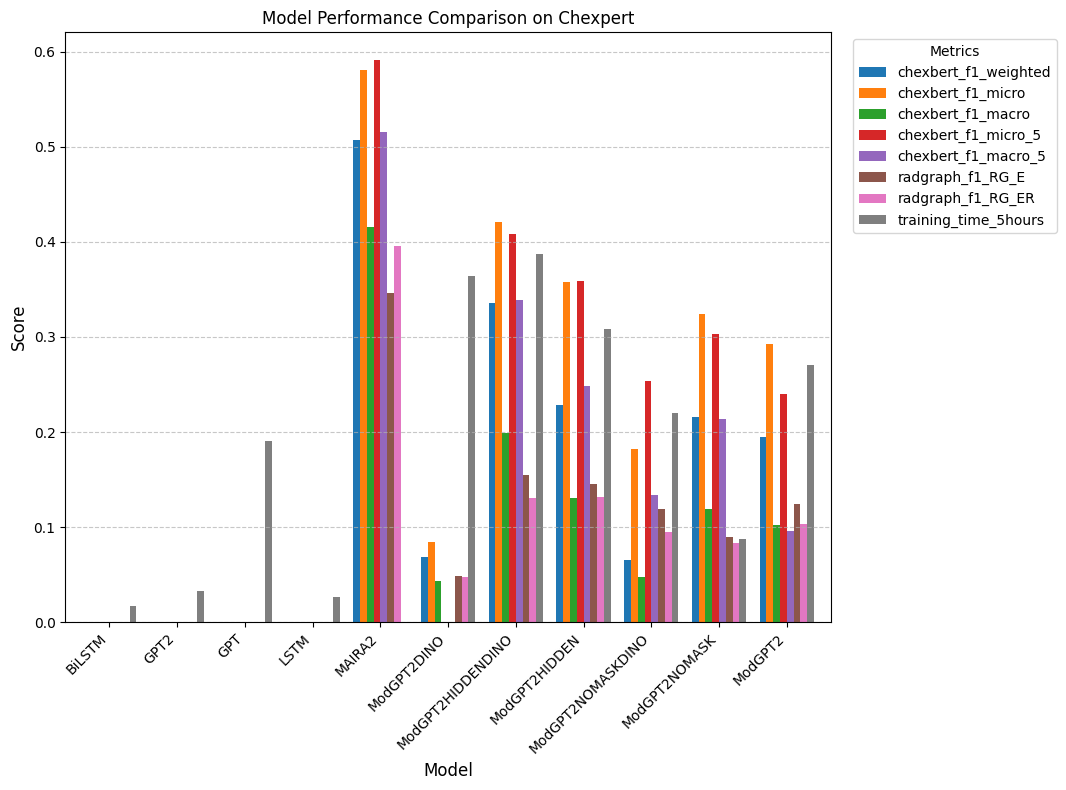

Plotting MIMIC metrics...
Convirtiendo training_time_seconds a horas/5 epochs para MIMIC...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en MIMIC
                       SAMEModGPT2DINO_10  SAMEModGPT2HIDDENDINO_10  SAMEModGPT2HIDDEN_10  SAMEModGPT2NOMASKDINO_10  SAMEModGPT2NOMASK_10  SAMEModGPT2_10
chexbert_f1_weighted               0.3296                    0.2766                0.3027                    0.2182                0.1617          0.2164
chexbert_f1_micro                  0.3500                    0.2888                0.3278                    0.2648                0.2563          0.2453
chexbert_f1_macro                  0.2091                    0.1845                0.1988                    0.1405                0.0975          0.1428
chexbert_f1_micro_5                0.3942                    0.3399                0.3476                    0.2224                0.2342          0.2434
chexbert_f1_macro_5                0.3153                    0.284

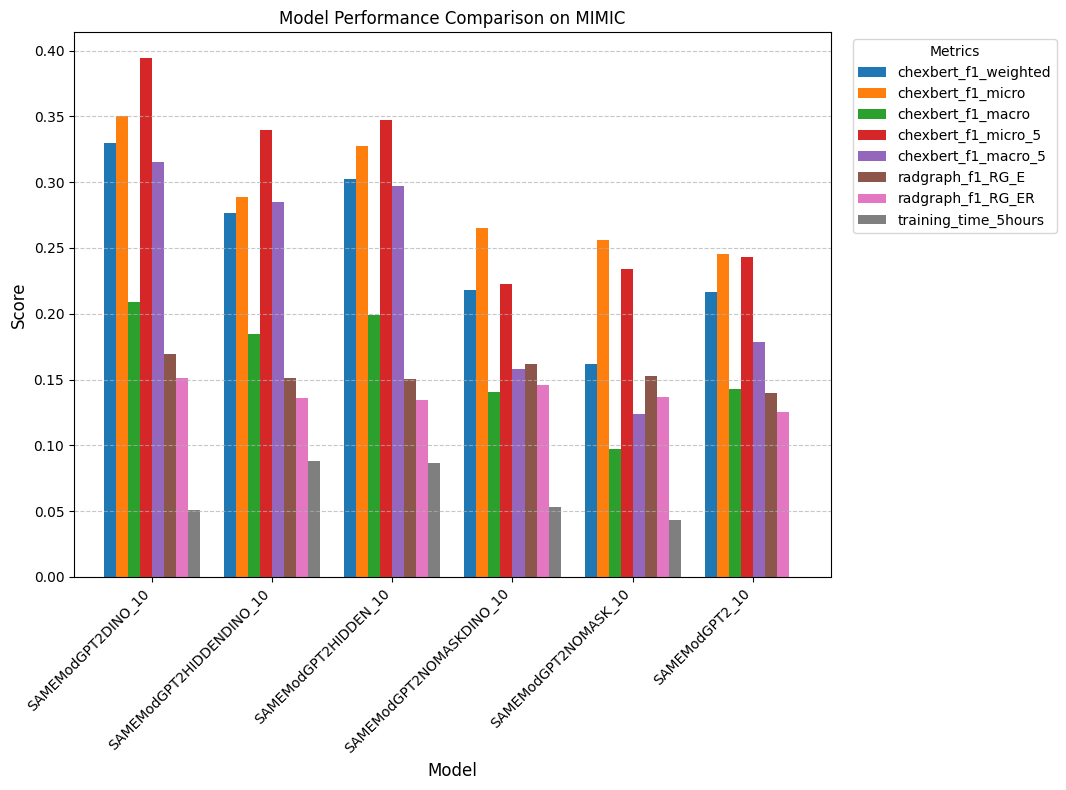

Plotting Selected MIMIC metrics...
Convirtiendo training_time_seconds a horas/5 epochs para Selected MIMIC Models...

Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en Selected MIMIC Models
                         ModGPT2  ModGPT2NOMASK  ModGPT2HIDDEN  ModGPT2DINO  ModGPT2NOMASKDINO  ModGPT2HIDDENDINO
chexbert_f1_weighted      0.2613         0.1214         0.2134       0.2838             0.2162             0.2520
chexbert_f1_micro         0.3159         0.1696         0.2773       0.3328             0.2489             0.3530
chexbert_f1_macro         0.1697         0.0715         0.1341       0.1718             0.1270             0.1522
chexbert_f1_micro_5       0.3370         0.1368         0.2394       0.3710             0.3364             0.3930
chexbert_f1_macro_5       0.2383         0.0832         0.1811       0.2692             0.2505             0.2363
radgraph_f1_RG_E          0.1609         0.1466         0.1578       0.1717             0.1888             0.17

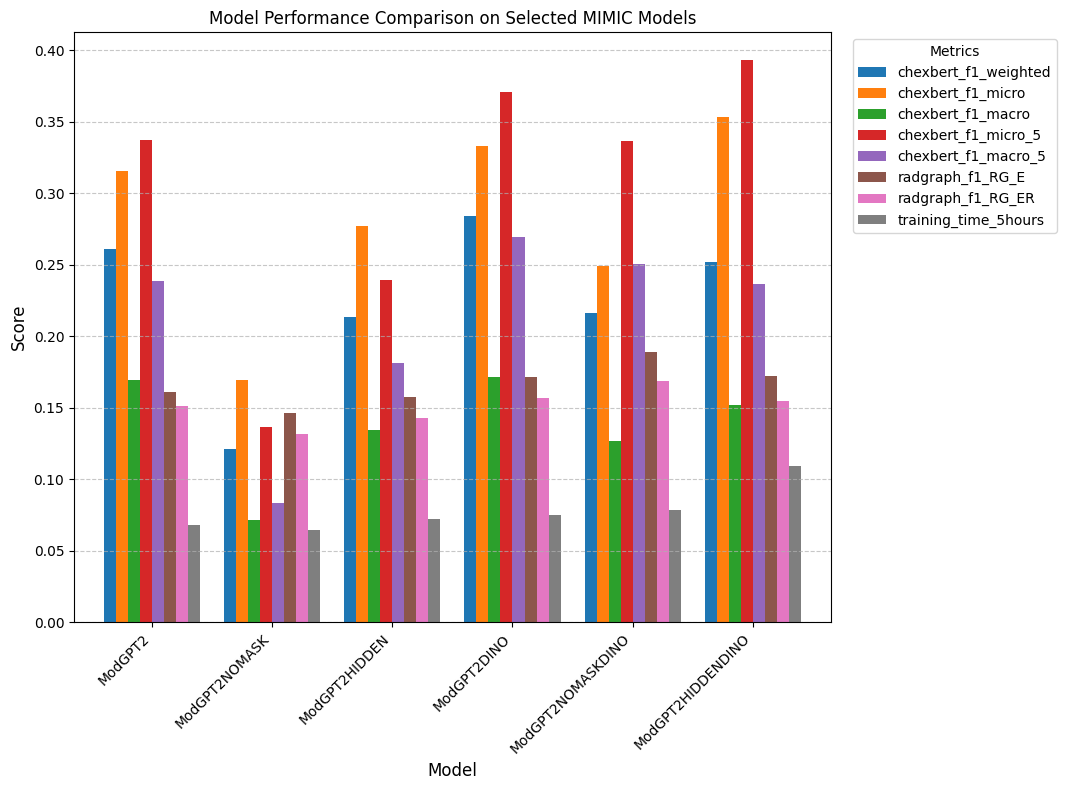

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Data from JSON Files ---
# (This loading code is the same as before)

json_paths_folder = "lstm-vs-gpt/results_complete"
json_files = [f for f in os.listdir(json_paths_folder) if f.endswith('.json')]

# Load Chexpert data
json_files_chexpert = [f for f in json_files if 'Chexpert' in f]
model_names_chexpert = [f.split('_')[0] for f in json_files_chexpert]
values_chexpert = {}
for i in range(len(model_names_chexpert)):
    model_name = model_names_chexpert[i]
    file_path = os.path.join(json_paths_folder, json_files_chexpert[i])
    try:
        with open(file_path, 'r') as f:
            values_chexpert[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Load MIMIC data
json_files_mimic = [f for f in json_files if 'MIMIC' in f]
json_files_mimic = [f for f in json_files_mimic if 'SAME' in f]
model_names_mimic = [f.split('_MIMIC')[0] for f in json_files_mimic]
values_mimic = {}
for i in range(len(model_names_mimic)):
    model_name = model_names_mimic[i]
    file_path = os.path.join(json_paths_folder, json_files_mimic[i])
    try:
        with open(file_path, 'r') as f:
            values_mimic[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Selected files
selected_json_files = ['ModGPT2_20_MIMIC.json', 'ModGPT2NOMASK_20_MIMIC.json', 'ModGPT2HIDDEN_20_MIMIC.json',
              'ModGPT2DINO_20_MIMIC.json', 'ModGPT2NOMASKDINO_20_MIMIC.json', 'ModGPT2HIDDENDINO_20_MIMIC.json']
selected_model_names = [f.split('_')[0] for f in selected_json_files]
values_selected_mimic = {}
for i in range(len(selected_model_names)):
    model_name = selected_model_names[i]
    file_path = os.path.join(json_paths_folder, selected_json_files[i])
    try:
        with open(file_path, 'r') as f:
            values_selected_mimic[model_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")


# --- 2. Plotting Function (UPDATED) ---

def plot_model_metrics(data_dict, dataset_name):
    """
    Creates a grouped bar chart and prints a formatted Pandas table for model metrics.
    
    Args:
        data_dict (dict): The dictionary {model_name: {metric: score}}.
        dataset_name (str): The name of the dataset (e.g., "MIMIC-CXR").
    """
    if not data_dict:
        print(f"No data to plot for {dataset_name}.")
        return

    # Convert the dictionary to a pandas DataFrame
    # Models are Columns, Metrics are Index (Rows)
    df = pd.DataFrame(data_dict)
    
    # Transpose for the Bar Chart: Models become Index (Rows), Metrics become Columns
    df_transposed_for_plot = df.T

    # --- Training Time Conversion ---
    if "training_time_seconds" in df_transposed_for_plot.columns:
        print(f"Convirtiendo training_time_seconds a horas/5 epochs para {dataset_name}...")
        
        # Convert seconds to hours / 5
        df_transposed_for_plot["training_time_seconds"] = df_transposed_for_plot["training_time_seconds"] / (3600 * 5)
        
        # Rename the column for the plot and the final table
        df_transposed_for_plot = df_transposed_for_plot.rename(
            columns={"training_time_seconds": "training_time_5hours"}
        )
        # Apply the rename back to the original structure 'df' too
        # df = df.rename(index={"training_time_seconds": "training_time_5hours"})
    
    # ------------------------------------------------------------
    ## 📝 Generación de Tabla (Usando Pandas)
    # ------------------------------------------------------------
    print("\n" + "="*80)
    print(f"Resultados Tabulares: Métricas (Filas) vs. Modelos (Columnas) en {dataset_name}")
    print("="*80)
    
    # El DataFrame 'df' ya tiene la estructura deseada:
    # Índice = Métricas
    # Columnas = Modelos
    df_final_table = df
    
    # Formato: Redondear los valores para una tabla limpia (ej. a 4 decimales)
    df_formatted = df_final_table.round(4)

    # Imprimir la tabla usando el método de impresión de Pandas (no Markdown)
    # Nota: Usamos .to_string() para asegurar que se imprima la tabla completa sin truncar columnas
    # o filas, aunque la simple impresión del DF también funciona en muchos entornos.
    print(df_formatted.to_string())
    print("="*80 + "\n")


    # ------------------------------------------------------------
    ## 📊 Generación de Gráfico
    # ------------------------------------------------------------

    # Create the grouped bar chart using the transposed DF
    ax = df_transposed_for_plot.plot(
        kind='bar', 
        figsize=(12, 8), 
        title=f'Model Performance Comparison on {dataset_name}',
        width=0.8
    )

    # --- Customize the plot ---
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Place the legend outside of the plotting area
    ax.legend(title='Metrics', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Add gridlines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent legend from being cut off
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    
    # Display the plot
    plt.show()

# --- 3. Generate the Plots ---

print("Plotting Chexpert metrics...")
plot_model_metrics(values_chexpert, "Chexpert")

print("Plotting MIMIC metrics...")
plot_model_metrics(values_mimic, "MIMIC")

print("Plotting Selected MIMIC metrics...")
plot_model_metrics(values_selected_mimic, "Selected MIMIC Models")

Reading newest file for MASK-DINO: events.out.tfevents.1765294586.DESKTOP_PC.18556.0
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
✅ Extracted 14 data points for MASK-DINO.
Reading newest file for MASK: events.out.tfevents.1765215787.DESKTOP_PC.110348.0
✅ Extracted 50 data points for MASK.
Reading newest file for HIDDEN-MASK: events.out.tfevents.1765223152.DESKTOP_PC.146608.0
✅ Extracted 46 data points for HIDDEN-MASK.
Reading newest file for HIDDEN-MASK-DINO: events.out.tfevents.1765238792.DESKTOP_PC.18692.0
✅ Extracted 50 data points for HIDDEN-MASK-DINO.
Reading newest file for NO-MASK: events.out.tfevents.1765249955.DESKTOP_PC.72092.0
✅ Extracted 50 data points for NO-MASK.
Reading newest file for NO-MASK-DINO: events.out.tfevents.1765301021.DESKTOP_PC.43260.0
✅ Extracted 50 data points for NO-MASK-DINO.


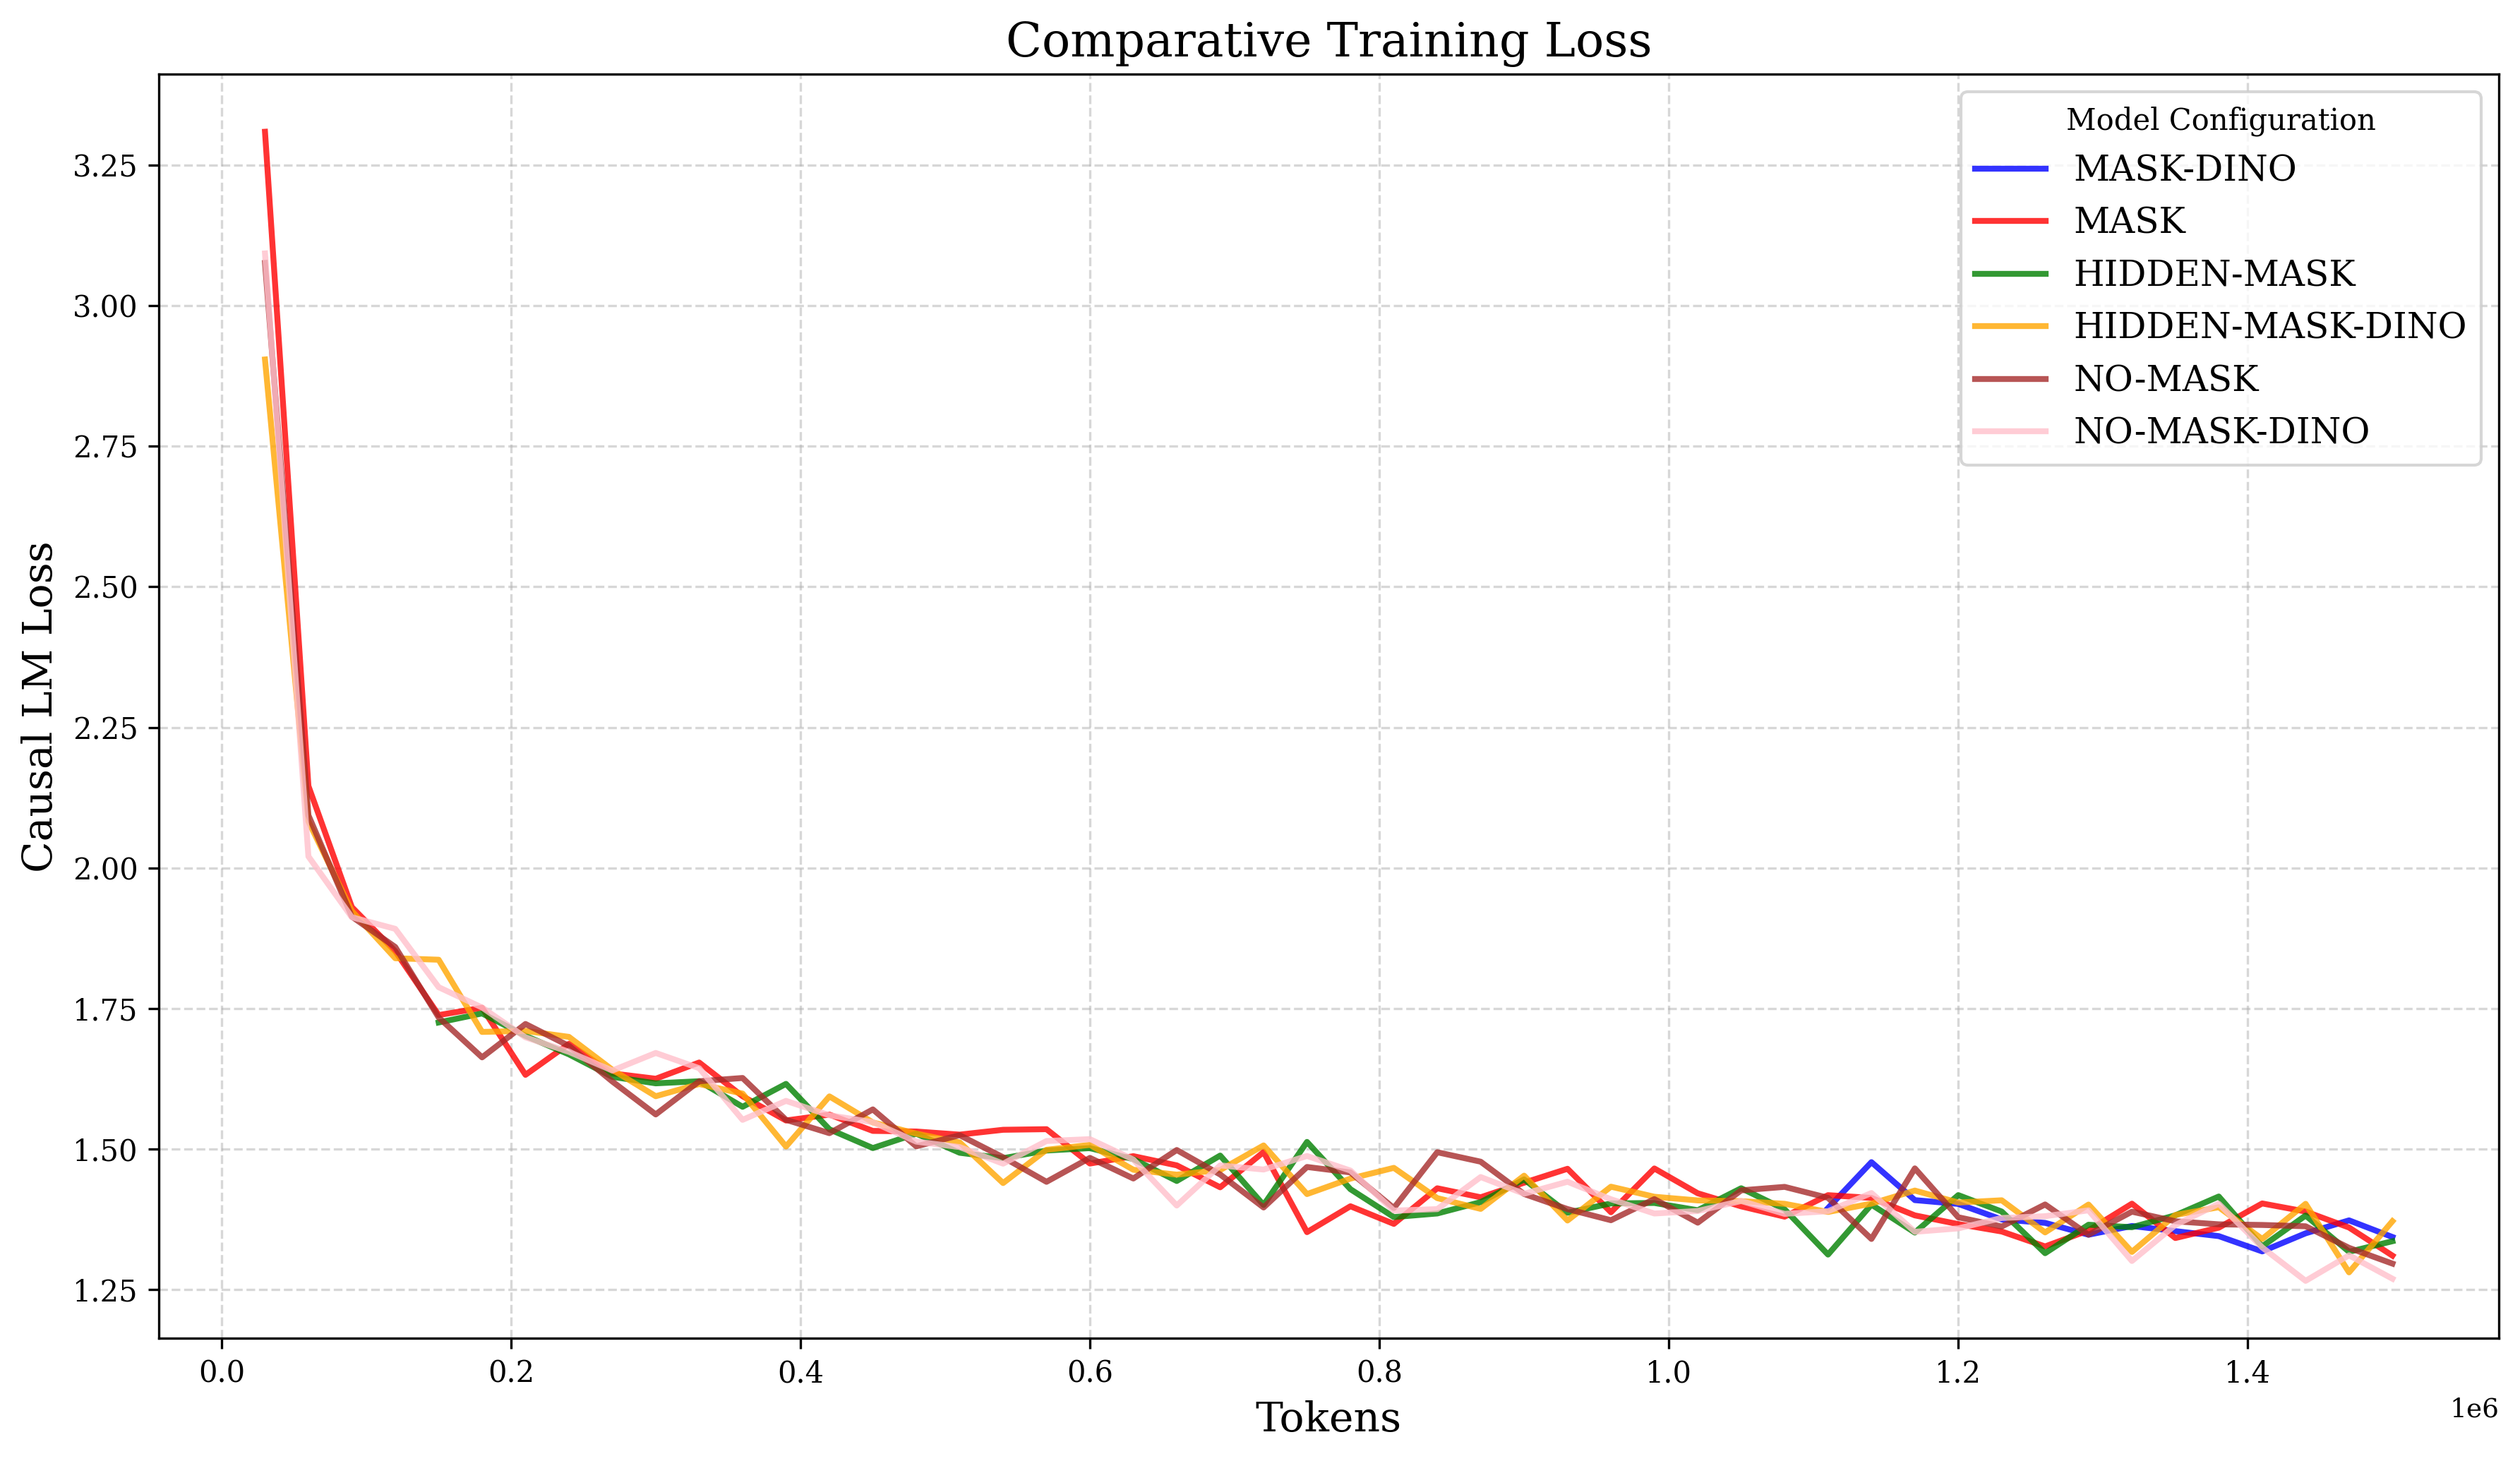

In [4]:
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import os 
import numpy as np
import glob

## 🚨 Configuration Adjusted for Folders 🚨

# 1. Define folder paths and their corresponding plot labels
# The script will automatically pick the newest "events.out.tfevents*" file in each folder.
LOG_FILES = [
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2DINO_findings/',
        'label': 'MASK-DINO',
        'color': 'blue'
    },
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2_findings/',
        'label': 'MASK',
        'color': 'red'
    },
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/',
        'label': 'HIDDEN-MASK',
        'color': 'green'
    },
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2HIDDENDINO_findings/',
        'label': 'HIDDEN-MASK-DINO',
        'color': 'orange'
    },
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2NOMASK_findings/',
        'label': 'NO-MASK',
        'color': 'brown'
    },
    {
        'folder': 'lstm-vs-gpt/runs/ModGPT2NOMASKDINO_findings/',
        'label': 'NO-MASK-DINO',
        'color': 'pink'
    }
]

LOSS_TAG = 'train/loss_epoch' 
STEP_TO_TOKEN_MULTIPLIER = 30000 

def get_latest_event_file(log_dir):
    """Finds the newest tfevents file in the given directory."""
    # Pattern to match TensorBoard event files
    pattern = os.path.join(log_dir, "events.out.tfevents.*")
    files = glob.glob(pattern)
    
    if not files:
        return None
    
    # Return the file with the latest modification time
    return max(files, key=os.path.getmtime)

def extract_scalar_data(event_file_path, tag):
    """Reads a TensorBoard event file and extracts step and scalar values for a given tag."""
    if not event_file_path or not os.path.exists(event_file_path):
        return None, None

    steps = []
    values = []

    try:
        for event in summary_iterator(event_file_path):
            if event.summary.value:
                for value in event.summary.value:
                    if value.tag == tag:
                        steps.append(event.step)
                        values.append(value.simple_value)
    except Exception as e:
        print(f"An error occurred while processing {event_file_path}: {e}")
        return None, None
        
    return steps, values

# --- Main Plotting Logic ---

plt.figure(figsize=(12, 7))
all_data_found = False

for log_info in LOG_FILES:
    folder_path = log_info['folder']
    label = log_info['label']
    color = log_info['color']
    
    # NEW: Automatically find the newest file in the folder
    actual_file_path = get_latest_event_file(folder_path)
    
    if actual_file_path:
        print(f"Reading newest file for {label}: {os.path.basename(actual_file_path)}")
        steps, losses = extract_scalar_data(actual_file_path, LOSS_TAG)
    else:
        print(f"❌ Error: No event files found in {folder_path}")
        steps, losses = None, None

    if steps:
        all_data_found = True
        print(f"✅ Extracted {len(steps)} data points for {label}.")

        tokens = [step * STEP_TO_TOKEN_MULTIPLIER for step in steps]
        
        plt.plot(
            tokens, 
            losses, 
            label=label, 
            color=color, 
            linewidth=2,
            alpha=0.8
        )
    else:
        print(f"❌ Warning: No data plotted for {label}.")

# --- Final Plot Customization ---

if all_data_found:
    plt.title('Comparative Training Loss', fontsize=16)
    plt.xlabel('Tokens', fontsize=14)
    plt.ylabel('Causal LM Loss', fontsize=14)
    plt.legend(title='Model Configuration', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data could be extracted. Check folder paths or LOSS_TAG.")

✅ Extracted 50 data points for MASK (from events.out.tfevents.1765215787.DESKTOP_PC.110348.0)
✅ Extracted 46 data points for HIDDEN-MASK (from events.out.tfevents.1765223152.DESKTOP_PC.146608.0)
✅ Extracted 50 data points for NO-MASK (from events.out.tfevents.1765249955.DESKTOP_PC.72092.0)
Figure saved as: assets/training_loss_no_dino.png


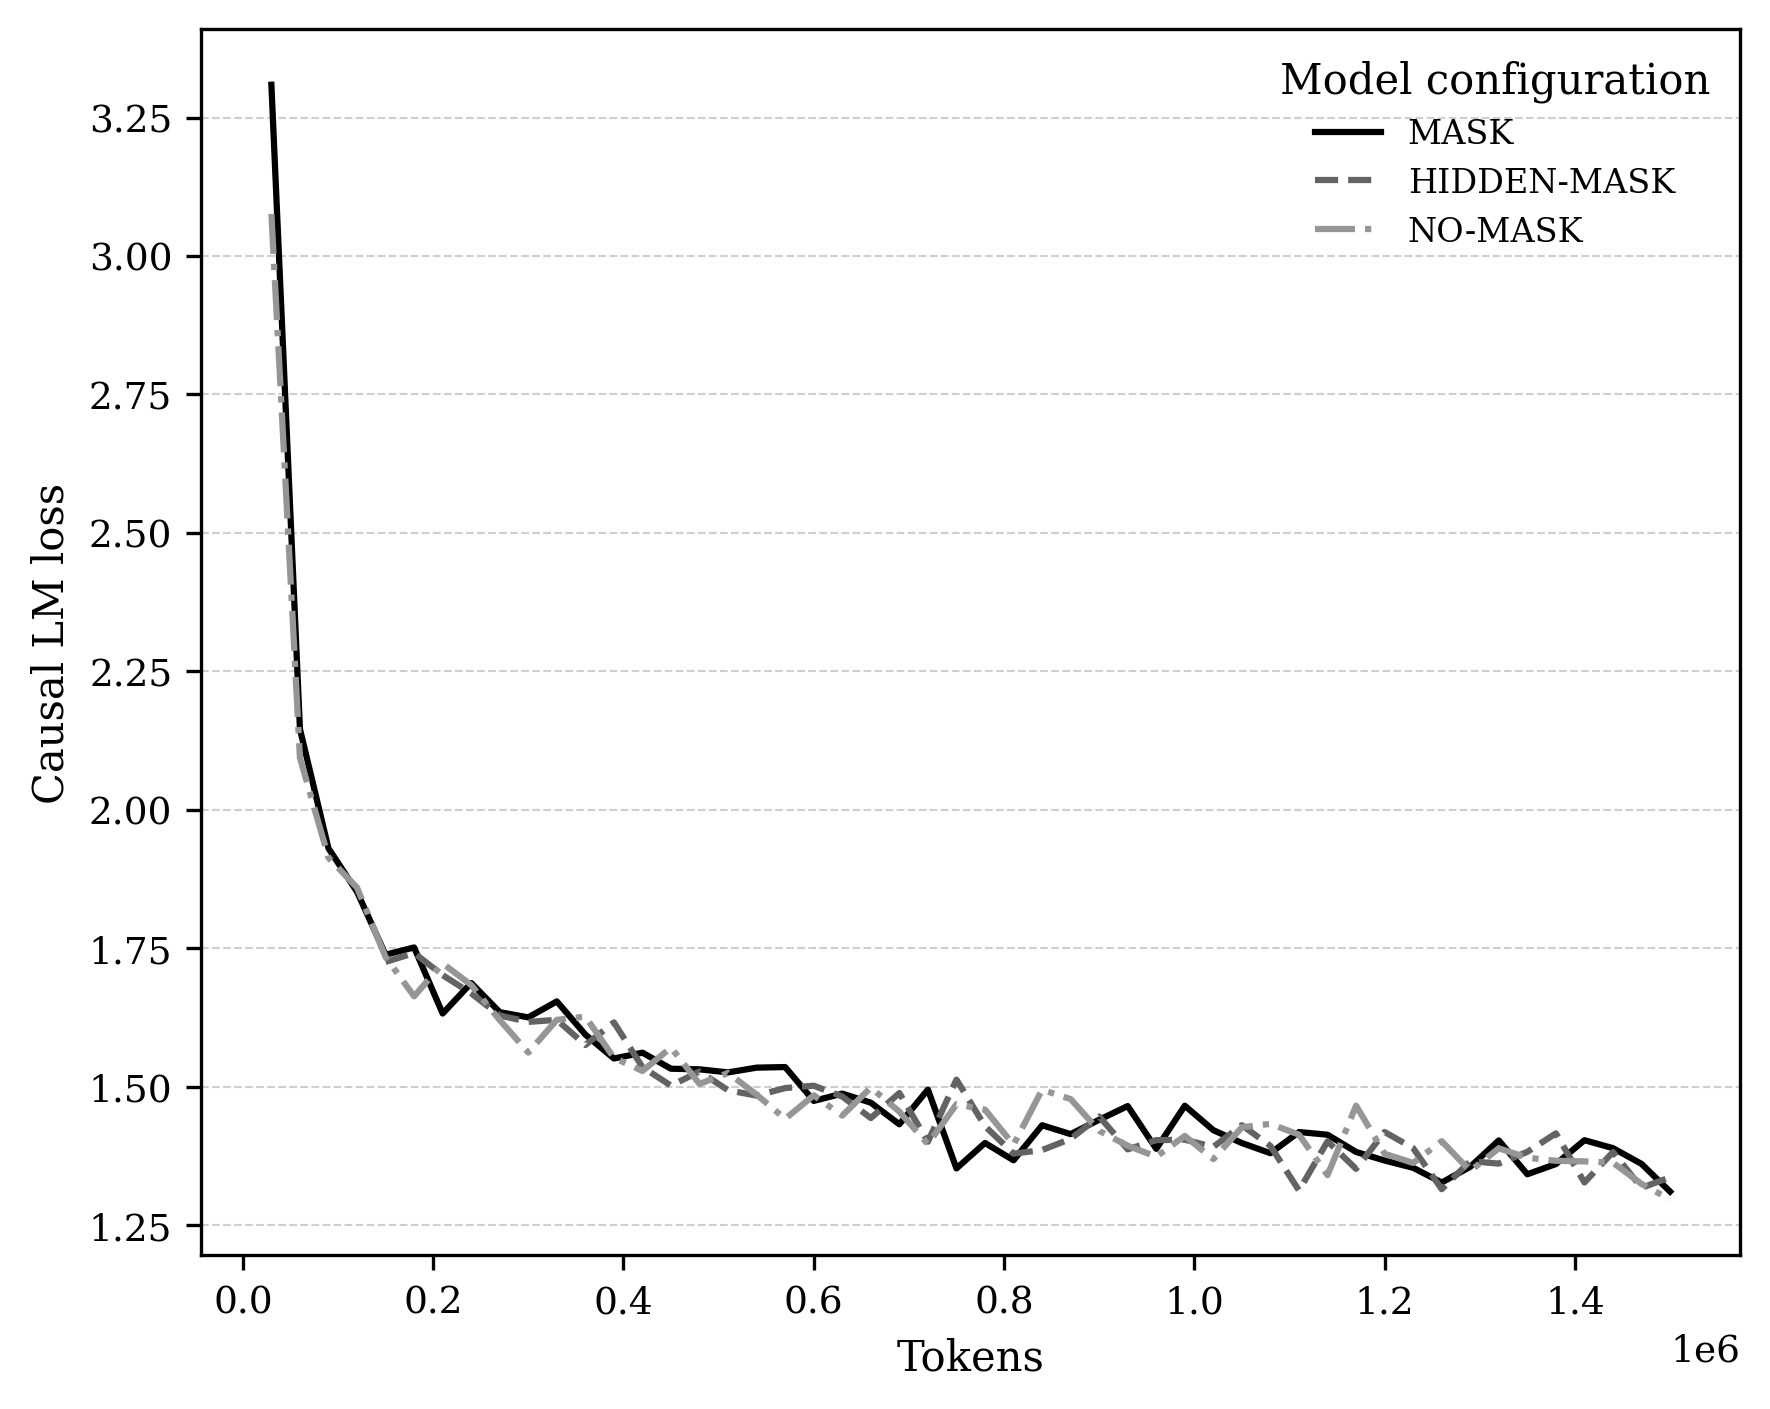

In [5]:
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import numpy as np
import glob
import warnings

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# Estilo global tipo paper
# ------------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
})

# ------------------------------------------------------------
# 1. Configuración de los experimentos (Folders only)
# ------------------------------------------------------------

# The script will pick the newest tfevents file from each folder
# and filter out any labels that contain "DINO"
LOG_CONFIGS = [
    {'folder': 'lstm-vs-gpt/runs/ModGPT2DINO_findings/',        'label': 'MASK-DINO'},
    {'folder': 'lstm-vs-gpt/runs/ModGPT2_findings/',            'label': 'MASK'},
    {'folder': 'lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/',      'label': 'HIDDEN-MASK'},
    {'folder': 'lstm-vs-gpt/runs/ModGPT2HIDDENDINO_findings/',  'label': 'HIDDEN-MASK-DINO'},
    {'folder': 'lstm-vs-gpt/runs/ModGPT2NOMASK_findings/',      'label': 'NO-MASK'},
    {'folder': 'lstm-vs-gpt/runs/ModGPT2NOMASKDINO_findings/',  'label': 'NO-MASK-DINO'}
]

LOSS_TAG = 'train/loss_epoch'
STEP_TO_TOKEN_MULTIPLIER = 30000

def get_latest_event_file(log_dir):
    """Finds the newest tfevents file in the given directory."""
    pattern = os.path.join(log_dir, "events.out.tfevents.*")
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.getmtime)

def extract_scalar_data(event_file_path, tag):
    """Reads a TensorBoard event file and extracts step and scalar values."""
    if not event_file_path or not os.path.exists(event_file_path):
        return None, None

    steps, values = [], []
    try:
        for event in summary_iterator(event_file_path):
            if event.summary.value:
                for value in event.summary.value:
                    if value.tag == tag:
                        steps.append(event.step)
                        values.append(value.simple_value)
    except Exception as e:
        print(f"Error processing {event_file_path}: {e}")
        return None, None
    return steps, values

# ------------------------------------------------------------
# 2. Lógica principal de ploteo
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4.8))
all_data_found = False

# Grayscale styles for publication
line_colors = ['black', '#636363', '#969696']
line_styles = ['-', '--', '-.']
color_idx = 0

for config in LOG_CONFIGS:
    label = config['label']
    
    # --- FILTER: Skip models with "DINO" in the label ---
    if "DINO" in label.upper():
        continue

    folder_path = config['folder']
    actual_file_path = get_latest_event_file(folder_path)

    if not actual_file_path:
        print(f"❌ No event files found in {folder_path}")
        continue

    steps, losses = extract_scalar_data(actual_file_path, LOSS_TAG)

    if steps:
        all_data_found = True
        print(f"✅ Extracted {len(steps)} data points for {label} (from {os.path.basename(actual_file_path)})")

        tokens = np.array(steps, dtype=float) * STEP_TO_TOKEN_MULTIPLIER
        
        ax.plot(
            tokens,
            losses,
            label=label,
            color=line_colors[color_idx % len(line_colors)],
            linestyle=line_styles[color_idx % len(line_styles)],
            linewidth=1.5,
        )
        color_idx += 1
    else:
        print(f"❌ Warning: No data found for {label} at {LOSS_TAG}.")

# ------------------------------------------------------------
# 3. Acabados finales de la figura
# ------------------------------------------------------------

if all_data_found:
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Causal LM loss')
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_axisbelow(True)

    # Scientific notation for token count (X-axis)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    ax.legend(
        title='Model configuration',
        frameon=False,
        loc='upper right',
        ncol=1
    )

    plt.tight_layout()

    if not os.path.exists("assets"):
        os.makedirs("assets")
        
    png_path = "assets/training_loss_no_dino.png"
    plt.savefig(png_path, bbox_inches='tight')
    print(f"Figure saved as: {png_path}")

    plt.show()
else:
    print("\nNo data could be extracted. Check folder paths or filter logic.")

Error: File not found at: lstm-vs-gpt/runs/ModGPT2_findings/events.out.tfevents.1763862685.DESKTOP_PC.140616.0. Skipping.
❌ Warning: No data plotted for MASK. File path or tag incorrect.
Error: File not found at: lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/events.out.tfevents.1763921184.DESKTOP_PC.192952.0. Skipping.
❌ Warning: No data plotted for HIDDEN-MASK. File path or tag incorrect.
Error: File not found at: lstm-vs-gpt/runs/ModGPT2NOMASK_findings/events.out.tfevents.1763857958.DESKTOP_PC.116212.0. Skipping.
❌ Warning: No data plotted for NO-MASK. File path or tag incorrect.

No data could be extracted from any file. Cannot generate plot.


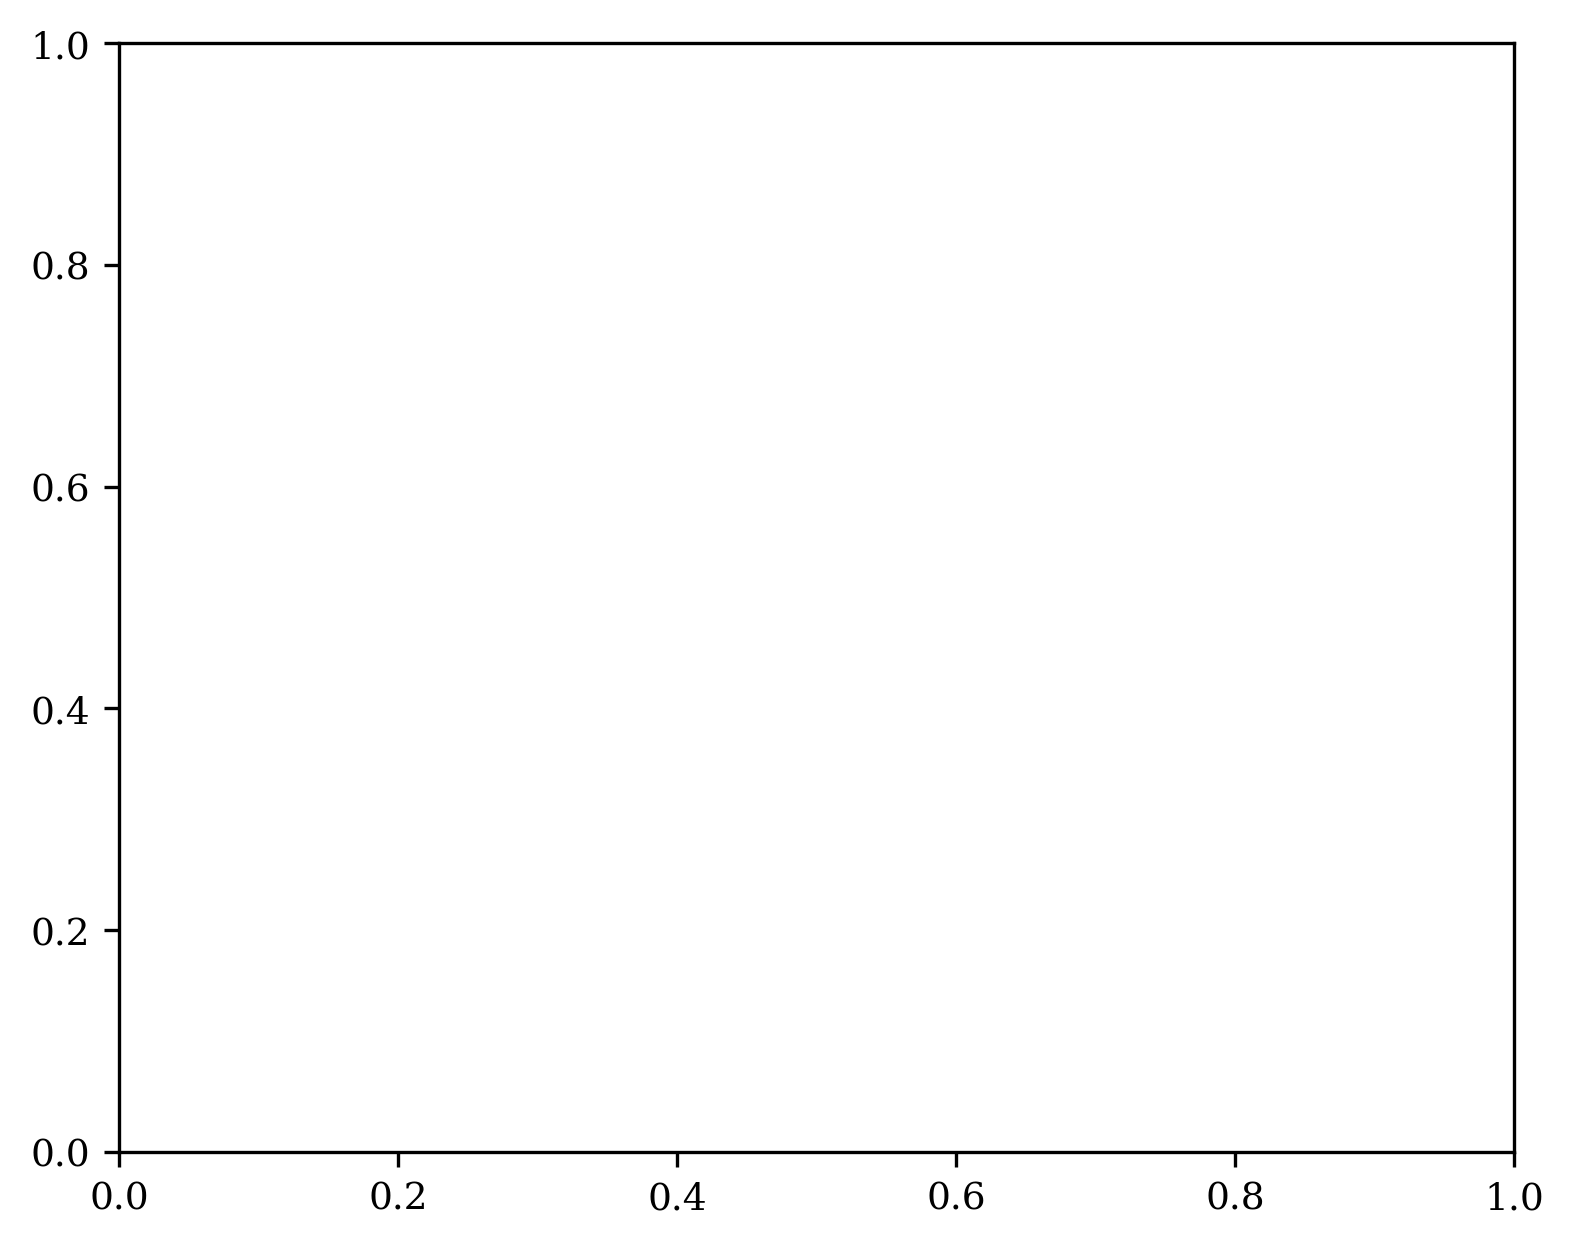

In [6]:
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# Estilo global tipo paper
# ------------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
})

# ------------------------------------------------------------
# 1. Configuración de los experimentos
# ------------------------------------------------------------

LOG_FILES = [
    # {
    #     'path': 'lstm-vs-gpt/runs/ModGPT2DINO_findings/events.out.tfevents.1763868601.DESKTOP_PC.167500.0',
    #     'label': 'MASK-DINO',
    # },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2_findings/events.out.tfevents.1763862685.DESKTOP_PC.140616.0',
        'label': 'MASK',
    },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2HIDDEN_findings/events.out.tfevents.1763921184.DESKTOP_PC.192952.0',
        'label': 'HIDDEN-MASK',
    },
    # {
    #     'path': 'lstm-vs-gpt/runs/ModGPT2HIDDENDINO_findings/events.out.tfevents.1763924080.DESKTOP_PC.68584.0',
    #     'label': 'HIDDEN-MASK-DINO',
    # },
    {
        'path': 'lstm-vs-gpt/runs/ModGPT2NOMASK_findings/events.out.tfevents.1763857958.DESKTOP_PC.116212.0',
        'label': 'NO-MASK',
    },
    # {
    #     'path': 'lstm-vs-gpt/runs/ModGPT2NOMASKDINO_findings/events.out.tfevents.1763932852.DESKTOP_PC.246260.0',
    #     'label': 'NO-MASK-DINO',
    # }
]

LOSS_TAG = 'train/loss_epoch'

# Si 1 step = 30,000 tokens, entonces tokens = step * 30000
STEP_TO_TOKEN_MULTIPLIER = 30000


def extract_scalar_data(event_file_path, tag):
    """Reads a TensorBoard event file and extracts step and scalar values for a given tag."""
    if not os.path.exists(event_file_path):
        print(f"Error: File not found at: {event_file_path}. Skipping.")
        return None, None

    steps = []
    values = []

    try:
        for event in summary_iterator(event_file_path):
            if event.summary.value:
                for value in event.summary.value:
                    if value.tag == tag:
                        steps.append(event.step)
                        values.append(value.simple_value)
    except Exception as e:
        print(f"An error occurred while processing {event_file_path}: {e}. Skipping.")
        return None, None

    return steps, values


# ------------------------------------------------------------
# 2. Lógica principal de ploteo (formato paper)
# ------------------------------------------------------------

# Figura tipo columna de paper: más alta que tu versión original
fig, ax = plt.subplots(figsize=(6, 4.8))
all_data_found = False

for log_info in LOG_FILES:
    file_path = log_info['path']
    label = log_info['label']

    steps, losses = extract_scalar_data(file_path, LOSS_TAG)

    if steps:
        all_data_found = True
        print(f"✅ Extracted {len(steps)} data points for {label}.")

        # Convert steps (epochs) to tokens
        tokens = np.array(steps, dtype=float) * STEP_TO_TOKEN_MULTIPLIER

        # ----------------------------------------------------
        # Determinación semántica de color y estilo
        # ----------------------------------------------------
        
        # Color según estrategia de enmascarado
        if 'NO-MASK' in label:
            color = '#1f77b4'  # Azul (Tab10)
        elif 'HIDDEN' in label:
            color = '#ff7f0e'  # Naranja (Tab10)
        else:
            color = '#2ca02c'  # Verde (Tab10) para MASK estándar

        # Estilo según arquitectura (DINO vs Estándar)
        if 'DINO' in label:
            linestyle = '--'   # Discontinuo
        else:
            linestyle = '-'    # Sólido

        ax.plot(
            tokens,
            losses,
            label=label,
            color=color,
            linestyle=linestyle,
            linewidth=1.5,
            alpha=0.9
        )
    else:
        print(f"❌ Warning: No data plotted for {label}. File path or tag incorrect.")


# ------------------------------------------------------------
# 3. Acabados finales de la figura
# ------------------------------------------------------------

if all_data_found:
    # Sin título interno; el título va en la leyenda/caption del paper
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Causal LM loss')

    # Grid solo horizontal, sutil
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.set_axisbelow(True)

    # Formato científico en el eje x si es grande
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Leyenda arriba, estilo limpio
    ax.legend(
        title='Model configuration',
        frameon=False,
        loc='upper right',
        ncol=1
    )

    plt.tight_layout()

    # Guardar en formatos listos para paper
    if not os.path.exists("assets"):
        os.makedirs("assets")
        
    png_path = "assets/training_loss_comparison.png"
    plt.savefig(png_path, bbox_inches='tight')
    print(f"Figure saved as: {png_path}")

    plt.show()
else:
    print("\nNo data could be extracted from any file. Cannot generate plot.")